# Prompt Engineering Techniques

This notebook contains examples demonstrating different prompt engineering techniques.
These examples not only covers how prompt engineering works but also details some of the concepts and key terms which every AI engineer should know while working with LLM prompts. 

- Basic Example with comparison of different parameters
- Text Summarization
- Question Answering 
- Text Classification
- Role Playing
- Code Generation
- Reasoning

### Advanced Techniques: 
| Zero shot | Few shot | CoT |
|----------|----------|----------|
| Self Consistency | Generate knowledge prompting | Prompt chaining |
| Tree of thoughts | RAG | Automatic reasoning and tool use |
| Automatic prompt engineer | Active-prompt | Directional Stimulus prompting |
| Program aided language models | ReAct | Multimodal CoT |


###### References: [Microsoft learn Prompt Engg](https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/advanced-prompt-engineering?pivots=programming-language-chat-completions)  | [arXiv Research Papers](https://arxiv.org/) | [Prompting guide](https://www.promptingguide.ai/techniques)

---

In [1]:
#checking current dir
import os
cwd = os.getcwd()
cwd

'c:\\Users\\nileshjoshi\\git\\aoai-poc'

In my virtual environment, I have already installed libraries, below commands to get details of libraries installed

In [3]:
%pip show openai

Name: openai
Version: 1.10.0
Summary: The official Python library for the openai API
Home-page: 
Author: 
Author-email: OpenAI <support@openai.com>
License: 
Location: c:\Users\nileshjoshi\AppData\Local\miniconda3\envs\aoaipoc\Lib\site-packages
Requires: anyio, distro, httpx, pydantic, sniffio, tqdm, typing-extensions
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip freeze

aiohttp==3.9.3
aiosignal==1.3.1
annotated-types==0.6.0
anyio==4.2.0
asttokens @ file:///opt/conda/conda-bld/asttokens_1646925590279/work
attrs==23.2.0
azure-ai-ml==1.13.0
azure-common==1.1.28
azure-core==1.29.7
azure-identity==1.15.0
azure-mgmt-core==1.4.0
azure-storage-blob==12.19.0
azure-storage-file-datalake==12.14.0
azure-storage-file-share==12.15.0
cachetools==5.3.2
certifi==2023.11.17
cffi==1.16.0
charset-normalizer==3.3.2
colorama==0.4.6
comm @ file:///work/ci_py311/comm_1677709131612/work
cryptography==42.0.2
dataclasses-json==0.6.4
debugpy @ file:///croot/debugpy_1690905042057/work
decorator @ file:///opt/conda/conda-bld/decorator_1643638310831/work
distro==1.9.0
executing @ file:///opt/conda/conda-bld/executing_1646925071911/work
frozenlist==1.4.1
google-api-core==2.16.1
google-auth==2.27.0
googleapis-common-protos==1.62.0
greenlet==3.0.3
h11==0.14.0
httpcore==1.0.2
httpx==0.26.0
idna==3.6
ipykernel @ file:///croot/ipykernel_1705933831282/work
ipython @ file:///croot/ipython_

In [2]:
#import required libraries 
import openai
from openai import AzureOpenAI
import os
import IPython
from langchain.llms import OpenAI
from dotenv import load_dotenv

In [3]:
#Load environment variables from env file. 
load_dotenv("credentials.env", override=True)

# API configuration
openai.api_key = os.getenv("AZURE_OPENAI_API_KEY")
MODEL_DEPLOYMENT_NAME = "gpt-35-turbo"
# set variables required for LangChain
os.environ["OPENAI_API_TYPE"]=os.environ["OPENAI_API_TYPE"]
os.environ["OPENAI_API_VERSION"] = os.environ["AZURE_OPENAI_API_VERSION"]
os.environ["OPENAI_API_BASE"]= os.environ["AZURE_OPENAI_ENDPOINT"] # Your Azure OpenAI resource endpoint
os.environ["OPENAI_API_KEY"]= os.environ["AZURE_OPENAI_API_KEY"] # Your Azure OpenAI resource key

In [4]:
#set_openAI_params method - to set parameters for Open AI model
#Default:  'temperature=0.7' and 'top-p=1'

def set_openAI_params(
    model=MODEL_DEPLOYMENT_NAME,
    temperature=0.7,
    max_tokens=256,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0,
):
    """ set openai parameters"""

    openai_params = {}    

    openai_params['model'] = model
    openai_params['temperature'] = temperature
    openai_params['max_tokens'] = max_tokens
    openai_params['top_p'] = top_p
    openai_params['frequency_penalty'] = frequency_penalty
    openai_params['presence_penalty'] = presence_penalty
    return openai_params

#completion method : To call AOAI API
def get_completion(params, messages):
    """ GET completion from openai api"""
    client = AzureOpenAI(
        azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"), 
        api_key=os.getenv("AZURE_OPENAI_API_KEY"),  
        api_version="2023-12-01-preview" #Function calling works in this API
    )
    response = client.chat.completions.create(
        model=MODEL_DEPLOYMENT_NAME,
        messages=messages,
        temperature = params['temperature'],
        max_tokens = params['max_tokens'],
        top_p = params['top_p'],
        frequency_penalty = params['frequency_penalty'],
        presence_penalty = params['presence_penalty']
    )    
    return response

### 1.0 Basic prompt example:

In [5]:
# basic example
params = set_openAI_params(temperature=1, max_tokens=1000)

prompt = "The sky is"

messages = [
    {
        "role": "user",
        "content": prompt
    }
]

response = get_completion(params, messages)

In [13]:
response.choices[0].message.content

' blue and filled with fluffy white clouds.'

Try with different temperature to compare results:

In [7]:
params = set_openAI_params(temperature=0)
response = get_completion(params, messages)
IPython.display.Markdown(response.choices[0].message.content)

 blue with fluffy white clouds.

**Temperature**: Controls randomness. Lowering the temperature means that the model produces more repetitive and deterministic responses. Increasing the temperature results in more unexpected or creative responses. Try adjusting temperature or Top P but not both.

**Top probabilities:** Similar to temperature, this controls randomness but uses a different method. Lowering Top P narrows the model’s token selection to likelier tokens. Increasing Top P lets the model choose from tokens with both high and low likelihood. Try adjusting temperature or Top P but not both.

Reference for more details: https://learn.microsoft.com/en-us/azure/ai-services/openai/chatgpt-quickstart?tabs=command-line%2Cpython&pivots=programming-language-studio#settings


### 1.1 Text Summarization

In [10]:
params = set_openAI_params(temperature=0.7)
prompt = """Antibiotics are a type of medication used to treat bacterial infections. They work by either killing the bacteria or preventing them from reproducing, allowing the body's immune system to fight off the infection. Antibiotics are usually taken orally in the form of pills, capsules, or liquid solutions, or sometimes administered intravenously. They are not effective against viral infections, and using them inappropriately can lead to antibiotic resistance. 

Explain the above in one sentence:"""

messages = [
    {
        "role": "user",
        "content": prompt
    }
]

response = get_completion(params, messages)
IPython.display.Markdown(response.choices[0].message.content)

Antibiotics are medications that treat bacterial infections by killing or preventing the reproduction of bacteria, but are not effective against viral infections and should be used carefully to avoid antibiotic resistance.

In [11]:
params = set_openAI_params(temperature=0.7)
prompt = """ I am 5. 
Explain the above in one sentence:"""

messages = [
    {
        "role": "user",
        "content": prompt
    }
]

response = get_completion(params, messages)
IPython.display.Markdown(response.choices[0].message.content)

I am five years old.

### 1.2 Question Answering

In [12]:
prompt = """Answer the question based on the context below. Keep the answer short and concise. Respond "Unsure about answer" if not sure about the answer.

Context: Teplizumab traces its roots to a New Jersey drug company called Ortho Pharmaceutical. There, scientists generated an early version of the antibody, dubbed OKT3. Originally sourced from mice, the molecule was able to bind to the surface of T cells and limit their cell-killing potential. In 1986, it was approved to help prevent organ rejection after kidney transplants, making it the first therapeutic antibody allowed for human use.

Question: What was OKT3 originally sourced from?

Answer:"""

messages = [
    {
        "role": "user",
        "content": prompt
    }
]

response = get_completion(params, messages)
IPython.display.Markdown(response.choices[0].message.content)


Mice.

### 1.3 Text Classification

In [13]:
prompt = """Classify the text into neutral, negative or positive.

Text: I think the food was okay.

Sentiment:"""

messages = [
    {
        "role": "user",
        "content": prompt
    }
]

response = get_completion(params, messages)
IPython.display.Markdown(response.choices[0].message.content)

Neutral

Below is modification to same prompt to instruct the model to provide an explanation to the answer selected. 

In [14]:
prompt = """Classify the text into neutral, negative or positive.

Text: I think the food was okay.

Provide sentiment and explaination about the same in details"""

messages = [
    {
        "role": "user",
        "content": prompt
    }
]

response = get_completion(params, messages)
IPython.display.Markdown(response.choices[0].message.content)

Sentiment: Neutral

Explanation: The statement "I think the food was okay" expresses a neutral sentiment. The use of "okay" suggests that the food was neither particularly good nor particularly bad, indicating a neutral opinion.

### 1.4 Role Playing

In [15]:
prompt = """The following is a conversation with an AI research assistant. The assistant tone is technical and scientific.

Human: Hello, who are you?
AI: Greeting! I am an AI research assistant. How can I help you today?
Human: Can you tell me about the creation of blackholes?
AI:"""

messages = [
    {
        "role": "user",
        "content": prompt
    }
]


response = get_completion(params, messages)
IPython.display.Markdown(response.choices[0].message.content)

Black holes are formed when a massive star collapses under its own gravity, causing its core to condense into a singular point of infinite density called a singularity. This process is known as gravitational collapse. As the star's core collapses, it releases a tremendous amount of energy, leading to the formation of a black hole with a strong gravitational pull that not even light can escape from. This phenomenon is a key aspect of astrophysical research and has profound implications for our understanding of the universe.

Role Playing example of using Open AI model as customer support agent. Provide necessary instructions about personality of the AI support agent

In [16]:
prompt = """You are an Xbox customer support agent whose primary goal is to help users with issues they are experiencing with their Xbox devices.
You are friendly and concise. You only provide factual answers to queries, and do not provide answers that are not related to Xbox."""

messages = [
    {
        "role": "system",
        "content": prompt
    }
]

messages = [
    {
        "role": "user",
        "content": "How do I perform factory reset? "
    }

]

response = get_completion(params, messages)
IPython.display.Markdown(response.choices[0].message.content)

Performing a factory reset on a device varies depending on the type of device you have. Here are some general steps for common devices:

1. Android phone or tablet: Go to Settings > System > Reset options > Erase all data (factory reset). Follow the on-screen instructions to confirm the reset.

2. iPhone or iPad: Go to Settings > General > Reset > Erase All Content and Settings. Follow the on-screen instructions to confirm the reset.

3. Windows PC: Go to Settings > Update & Security > Recovery > Reset this PC. Follow the on-screen instructions to reset your PC.

4. Mac computer: Restart your Mac and hold down Command + R until the Apple logo appears. Select Disk Utility > Continue > Erase. After erasing, select Reinstall macOS from the Utilities window.

It's important to note that performing a factory reset will erase all data on your device, so be sure to back up any important information before proceeding.

### 1.5 Code Generation

In [17]:
prompt = "\"\"\"\nTable departments, columns = [DepartmentId, DepartmentName]\nTable students, columns = [DepartmentId, StudentId, StudentName]\nCreate a MySQL query for all students in the Computer Science Department\n\"\"\""

messages = [
    {
        "role": "user",
        "content": prompt
    }
]

response = get_completion(params, messages)
IPython.display.Markdown(response.choices[0].message.content)


SELECT students.StudentId, students.StudentName
FROM students
JOIN departments ON students.DepartmentId = departments.DepartmentId
WHERE departments.DepartmentName = 'Computer Science'

### 1.6 Reasoning

In [18]:
prompt = """The odd numbers in this group add up to an even number: 15, 32, 5, 13, 82, 7, 1. 

Solve by breaking the problem into steps. First, identify the odd numbers, add them, and indicate whether the result is odd or even."""

messages = [
    {
        "role": "user",
        "content": prompt
    }
]

response = get_completion(params, messages)
IPython.display.Markdown(response.choices[0].message.content)

The odd numbers in the given group are 15, 5, 13, and 7. 

Adding them together: 
15 + 5 + 13 + 7 = 40

Since 40 is an even number, the result of adding the odd numbers is even.

Exercise: Improve the prompt to have a better structure and output format.

## 2. Advanced Prompting Techniques

Objectives:

- Cover more advanced techniques for prompting: few-shot, chain-of-thoughts,...

### 2.2 Few-shot prompts

In [19]:
prompt = """The odd numbers in this group add up to an even number: 4, 8, 9, 15, 12, 2, 1.
A: The answer is False.

The odd numbers in this group add up to an even number: 17,  10, 19, 4, 8, 12, 24.
A: The answer is True.

The odd numbers in this group add up to an even number: 16,  11, 14, 4, 8, 13, 24.
A: The answer is True.

The odd numbers in this group add up to an even number: 17,  9, 10, 12, 13, 4, 2.
A: The answer is False.

The odd numbers in this group add up to an even number: 15, 32, 5, 13, 82, 7, 1. 
A:"""

messages = [
    {
        "role": "user",
        "content": prompt
    }
]

response = get_completion(params, messages)
IPython.display.Markdown(response.choices[0].message.content)

The answer is False.

### 2.3 Chain-of-Thought (CoT) Prompting

Intuitively we as humans break a larger task or problem into sub-tasks, and then we chain these sub-tasks together. Using the output of one sub-task as the input for the next sub-task. By using such chain-of-thoughts prompting examples to LLM it is possible to develop sophisticated reasoning capabilities and generate right responses from models.

In [20]:
prompt = """The odd numbers in this group add up to an even number: 4, 8, 9, 15, 12, 2, 1.
A: Adding all the odd numbers (9, 15, 1) gives 25. The answer is False.

The odd numbers in this group add up to an even number: 15, 32, 5, 13, 82, 7, 1. 
A:"""

messages = [
    {
        "role": "user",
        "content": prompt
    }
]

response = get_completion(params, messages)
IPython.display.Markdown(response.choices[0].message.content)

Adding all the odd numbers (15, 5, 13, 7, 1) gives 41. The answer is False.

Another example: (showing difference in model's response based on which model you are using)

In [21]:
prompt = """Bob is in the living room.
He walks to the kitchen, carrying a cup.
He puts a ball in the cup and carries the cup to the bedroom.
He turns the cup upside down, then walks to the garden.
He puts the cup down in the garden, then walks to the garage.
Where is the ball?"""

messages = [
    {
        "role": "user",
        "content": prompt
    }
]

params = {
    "temperature": 1,
    "max_tokens": 100,
    "top_p": 1,
    "frequency_penalty": 0,
    "presence_penalty": 0
}
response = get_completion(params, messages)
IPython.display.Markdown(response.choices[0].message.content)

The ball is in the cup in the garden.

The correct answer is that the ball is in the bedroom. Although LLMs are non-deterministic, the responses I received during several attempts were as follows:

*GPT 3.5: The ball is in the garden. ❌

GPT 3.5 Turbo OR GPT 4: The ball is in the bedroom. [followed by an explanation] ✅

###### **Please note sometimes GPt 3.5 Turbo does provide correct answer but in most cases answer provided by 3.5 is wrong - especially when you are using higher temparature value.

Notice that depending on which model you are using you may get different response. GPT 3.5 doesnt provide right response (most times, if not always )and for that you may have to use different prompting technique. (Tree of thought explained below) But otherwise GPT 4 and other more powerful models gets you right answer with CoT approach. 

### 2.4 Zero-shot CoT

In [21]:
prompt = """I went to the market and bought 10 apples. I gave 2 apples to the neighbor and 2 to the repairman. I then went and bought 5 more apples and ate 1. How many apples did I remain with?

Let's think step by step."""

messages = [
    {
        "role": "user",
        "content": prompt
    }
]

response = get_completion(params, messages)
IPython.display.Markdown(response.choices[0].message.content)

Step 1: Bought 10 apples
Step 2: Gave 2 apples to neighbor (10 - 2 = 8)
Step 3: Gave 2 apples to repairman (8 - 2 = 6)
Step 4: Bought 5 more apples (6 + 5 = 11)
Step 5: Ate 1 apple (11 - 1 = 10)

So, you remained with 10 apples.

### 2.5 Self-Consistency
self-consistency aims "to replace the naive greedy decoding used in chain-of-thought prompting". The idea is to sample multiple, diverse reasoning paths through few-shot CoT, and use the generations to select the most consistent answer. This helps to boost the performance of CoT prompting on tasks involving arithmetic and commonsense reasoning.


---

In [22]:
prompt = """When I was 6 my sister was half my age.Now, I am 70 how old is my sister?"""

messages = [
    {
        "role": "user",
        "content": prompt
    }
]

response = get_completion(params, messages)
IPython.display.Markdown(response.choices[0].message.content)

Your sister is 68 years old.

above answer is wrong, in such scenarios we need to use CoT with Fewshots (aka Self consistency). See below

In [23]:
prompt = """Q: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done,
there will be 21 trees. How many trees did the grove workers plant today?
A: We start with 15 trees. Later we have 21 trees. The difference must be the number of trees they planted.
So, they must have planted 21 - 15 = 6 trees. The answer is 6.

Q: If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?
A: There are 3 cars in the parking lot already. 2 more arrive. Now there are 3 + 2 = 5 cars. The answer is 5.

Q: Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they have left in total?
A: Leah had 32 chocolates and Leah’s sister had 42. That means there were originally 32 + 42 = 74
chocolates. 35 have been eaten. So in total they still have 74 - 35 = 39 chocolates. The answer is 39.

Q: Jason had 20 lollipops. He gave Denny some lollipops. Now Jason has 12 lollipops. How many lollipops
did Jason give to Denny?
A: Jason had 20 lollipops. Since he only has 12 now, he must have given the rest to Denny. The number of
lollipops he has given to Denny must have been 20 - 12 = 8 lollipops. The answer is 8.

Q: Shawn has five toys. For Christmas, he got two toys each from his mom and dad. How many toys does
he have now?
A: He has 5 toys. He got 2 from mom, so after that he has 5 + 2 = 7 toys. Then he got 2 more from dad, so
in total he has 7 + 2 = 9 toys. The answer is 9.

Q: There were nine computers in the server room. Five more computers were installed each day, from
monday to thursday. How many computers are now in the server room?
A: There are 4 days from monday to thursday. 5 computers were added each day. That means in total 4 * 5 =
20 computers were added. There were 9 computers in the beginning, so now there are 9 + 20 = 29 computers.
The answer is 29.

Q: Michael had 58 golf balls. On tuesday, he lost 23 golf balls. On wednesday, he lost 2 more. How many
golf balls did he have at the end of wednesday?
A: Michael initially had 58 balls. He lost 23 on Tuesday, so after that he has 58 - 23 = 35 balls. On
Wednesday he lost 2 more so now he has 35 - 2 = 33 balls. The answer is 33.

Q: Olivia has $23. She bought five bagels for $3 each. How much money does she have left?
A: She bought 5 bagels for $3 each. This means she spent 5

Q: When I was 6 my sister was half my age. Now I’m 70 how old is my sister?
A:"""

messages = [
    {
        "role": "user",
        "content": prompt
    }
]

response = get_completion(params, messages)
IPython.display.Markdown(response.choices[0].message.content)

When you were 6, your sister was half your age, so she was 3 years younger than you. Now that you are 70, your sister is 70 - 3 = 67 years old.

### 2.6 Generate Knowledge Prompting

LLMs continue to be improved and one popular technique includes the ability to incorporate knowledge or information to help the model make more accurate predictions.

Using a similar idea, can the model also be used to generate knowledge before making a prediction? That's what is attempted in the paper by Liu et al. 2022 -- generate knowledge to be used as part of the prompt. In particular, how helpful is this for tasks such as commonsense reasoning?

In [24]:
prompt = """Part of golf is trying to get a higher point total than others. Yes or No?"""

messages = [
    {
        "role": "user",
        "content": prompt
    }
]

response = get_completion(params, messages)
IPython.display.Markdown(response.choices[0].message.content)

Yes, in golf, the objective is to complete the course with the fewest strokes possible, and the player with the lowest score wins. So, in a way, the goal is to have a lower point total than others.

This type of mistake reveals the limitations of LLMs to perform tasks that require more knowledge about the world. How do we improve this with knowledge generation?

First, we generate a few "knowledges"

In [25]:
prompt = """Question: Part of golf is trying to get a higher point total than others. Yes or No?

Knowledge: The objective of golf is to play a set of holes in the least number of strokes. A round of golf typically consists of 18 holes. Each hole is played once in the round on a standard golf course. Each stroke is counted as one point, and the total number of strokes is used to determine the winner of the game.

Explain and Answer: """

messages = [
    {
        "role": "user",
        "content": prompt
    }
]

response = get_completion(params, messages)
IPython.display.Markdown(response.choices[0].message.content)

No, the objective of golf is not to get a higher point total than others. The objective of golf is to play a set of holes in the least number of strokes. Each stroke is counted as one point, and the total number of strokes is used to determine the winner of the game. So, the goal is to have the lowest score, not the highest.

Thus above approach of feeding knowledge works better in such scenarios.

### 2.7 Prompt Chaining

Prompt chaining is the approach where you create multiple prompts. Assume you have 2 (or more) large documents and to summarize all documents. In this case due to token limitations you wont be able to send all documents through one single prompt to LLM and ask for summarization. You will have to build first prompt to get summary from document-1. Second prompt to generate summary from document-2 and then third prompt which will include prompt 1 and prompt 2 response and summarize both.

In [26]:
prompt1 = """Summarize below document in one sentence.
Azure SQL Database is always running on the latest stable version of the SQL Server database engine and patched OS with 99.99% availability. PaaS capabilities built into Azure SQL Database enable you to focus on the domain-specific database administration and optimization activities that are critical for your business. With Azure SQL Database, you can create a highly available and high-performance data storage layer for the applications and solutions in Azure. SQL Database can be the right choice for a variety of modern cloud applications because it enables you to process both relational data and nonrelational structures, such as graphs, JSON, spatial, and XML.

Azure SQL Database is based on the latest stable version of the Microsoft SQL Server database engine. You can use advanced query processing features, such as high-performance in-memory technologies and intelligent query processing. In fact, the newest capabilities of SQL Server are released first to Azure SQL Database, and then to SQL Server itself. You get the newest SQL Server capabilities with no overhead for patching or upgrading, tested across millions of databases.

SQL Database enables you to easily define and scale performance within two different purchasing models: a vCore-based purchasing model and a DTU-based purchasing model. SQL Database is a fully managed service that has built-in high availability, backups, and other common maintenance operations. Microsoft handles all patching and updating of the SQL and operating system code. You don't have to manage the underlying infrastructure.

If you're new to Azure SQL Database, check out the Azure SQL Database Overview video from our in-depth Azure SQL video series.
Purchasing models
SQL Database offers the following purchasing models:

The vCore-based purchasing model lets you choose the number of vCores, the amount of memory, and the amount and speed of storage. The vCore-based purchasing model also allows you to use Azure Hybrid Benefit for SQL Server to gain cost savings by leveraging your existing SQL Server licenses.
The DTU-based purchasing model offers a blend of compute, memory, and I/O resources in three service tiers, to support light to heavy database workloads. Compute sizes within each tier provide a different mix of these resources, to which you can add additional storage resources.
Service tiers
The vCore-based purchasing model offers three service tiers:

The General Purpose service tier is designed for common workloads. It offers budget-oriented balanced compute and storage options.
The Business Critical service tier is designed for OLTP applications with high transaction rates and low latency I/O requirements. It offers the highest resilience to failures by using several isolated replicas.
The Hyperscale service tier is designed for most business workloads. Hyperscale provides great flexibility and high performance with independently scalable compute and storage resources. It offers higher resilience to failures by allowing configuration of more than one isolated database replica.
The DTU-based purchasing model offers two service tiers:

The Standard service tier is designed for common workloads. It offers budget-oriented balanced compute and storage options.
The Premium service tier is designed for OLTP applications with high transaction rates and low latency I/O requirements. It offers the highest resilience to failures by using several isolated replicas.
Compute tiers
The vCore-based purchasing model provides two different compute tiers for Azure SQL Database - the provisioned compute tier, and the serverless compute tier. The DTU-based purchasing model provides just the provisioned compute tier.

Provisioned compute tier: provides a specific amount of compute resource that is continuously provisioned independent of workload activity, and bills for the amount of compute provisioned at a fixed price per hour.
Serverless compute tier: automatically scales compute resources based on workload activity and bills for the amount of compute used, per second. The serverless compute tier is generally available in the General Purpose service tier and in the Hyperscale service tier.
Deployment models
Azure SQL Database provides the following deployment options for a database:

Single database represents a fully managed, isolated database. You might use this option if you have modern cloud applications and microservices that need a single reliable data source. A single database is similar to a contained database in the SQL Server database engine.
Elastic pool is a collection of single databases with a shared set of resources, such as CPU or memory. Single databases can be moved into and out of an elastic pool.
 Important

To understand the feature differences between SQL Database, SQL Server, and Azure SQL Managed Instance, as well as the differences among different Azure SQL Database options, see SQL Database features.

SQL Database delivers predictable performance with multiple resource types, service tiers, and compute sizes. It provides dynamic scaling with no downtime, built-in intelligent optimization, global scalability and availability, and advanced security options. These capabilities allow you to focus on rapid app development and accelerating your time-to-market, rather than on managing virtual machines and infrastructure. SQL Database is currently in 38 datacenters around the world, so you can run your database in a datacenter near you.

Scalable performance and pools
You can define the amount of resources assigned.

With single databases, each database is isolated from others and is portable. Each has its own guaranteed amount of compute, memory, and storage resources. The amount of the resources assigned to the database is dedicated to that database, and isn't shared with other databases in Azure. You can dynamically scale single database resources up and down. The single database option provides different compute, memory, and storage resources for different needs. For example, you can get 1 to 128 vCores, or 32 GB to 4 TB. The Hyperscale service tier enables you to scale to 100 TB, with fast backup and restore capabilities.
With elastic pools, you can assign resources that are shared by all databases in the pool. You can create a new database, or move the existing single databases into a resource pool to maximize the use of resources and save money. This option also gives you the ability to dynamically scale elastic pool resources up and down.
 Note

Elastic pools for Hyperscale are currently in preview.

You can build your first app on a small, single database at a low cost per month in the General Purpose service tier. You can then change its service tier manually or programmatically at any time to the Business Critical or Hyperscale service tier, to meet the needs of your solution. You can adjust performance without downtime to your app or to your customers. Dynamic scaling enables your database to transparently respond to rapidly changing resource requirements. You pay for only the resources that you need when you need them.

Dynamic scaling is different from autoscaling. Autoscaling is when a service scales automatically based on criteria, whereas dynamic scaling allows for manual scaling without downtime. The single database option supports manual dynamic scaling, but not autoscale. For a more automatic experience, consider these alternatives:

Use the serverless tier, which does provide autoscaling.
Use scripts to schedule or automate scalability for a single database. For an example, see Use PowerShell to monitor and scale a single database.
Use elastic pools, which allow databases to share resources in a pool based on individual database needs. Elastic pools can also be scaled with custom scripts, allowing you to schedule or automate scalability.
Elastic pools to maximize resource utilization
For many businesses and applications, being able to create single databases and dial performance up or down on demand is enough, especially if usage patterns are relatively predictable. Unpredictable usage patterns can make it hard to manage costs and your business model. Elastic pools are designed to solve this problem. You allocate performance resources to a pool rather than an individual database. You pay for the collective performance resources of the pool rather than for single database performance.

Graphic that shows elastic pools in basic, standard, and premium editions

With elastic pools, you don't need to focus on dialing database performance up and down as demand for resources fluctuates. The pooled databases consume the performance resources of the elastic pool as needed. Pooled databases consume but don't exceed the limits of the pool, so your cost remains predictable even if individual database usage doesn't.

You can add and remove databases to the pool, scaling your app from a handful of databases to thousands, all within a budget that you control. You can also control the minimum and maximum resources available to databases in the pool, to ensure that no database in the pool uses all the pool resources, and that every pooled database has a guaranteed minimum amount of resources. To learn more about design patterns for software as a service (SaaS) applications that use elastic pools, see Design patterns for multitenant SaaS applications with SQL Database.

Scripts can help with monitoring and scaling elastic pools. For an example, see Use PowerShell to monitor and scale an elastic pool in Azure SQL Database.

Blend single databases with pooled databases
You can blend single databases with elastic pools, and change the service tiers of single databases and elastic pools to adapt to your situation. You can also mix and match other Azure services with SQL Database to meet your unique app design needs, drive cost and resource efficiencies, and unlock new business opportunities.

Extensive monitoring and alerting capabilities
Azure SQL Database provides advanced monitoring and troubleshooting features that help you get deeper insights into workload characteristics. These features and tools include:

The built-in monitoring capabilities provided by the latest version of the SQL Server database engine. They enable you to find real-time performance insights.
PaaS monitoring capabilities provided by Azure that enable you to monitor and troubleshoot a large number of database instances.
Query Store, a built-in SQL Server monitoring feature, records the performance of your queries in real time, and enables you to identify the potential performance issues and the top resource consumers. Automatic tuning and recommendations provide advice regarding the queries with the regressed performance and missing or duplicated indexes. Automatic tuning in SQL Database enables you to either manually apply the scripts that can fix the issues, or let SQL Database apply the fix. SQL Database can also test and verify that the fix provides some benefit, and retain or revert the change depending on the outcome. In addition to Query Store and automatic tuning capabilities, you can use standard DMVs and XEvents to monitor the workload performance.

You can efficiently monitor the status of thousands of databases by using the built-in performance monitoring and alerting features of SQL Database. Using these tools, you can quickly assess the impact of scaling up or down, based on your current or projected performance needs. Additionally, SQL Database can emit metrics and resource logs for easier monitoring. You can configure SQL Database to store resource usage, workers and sessions, and connectivity into one of these Azure resources:

Azure Storage: For archiving vast amounts of telemetry for a small price.
Azure Event Hubs: For integrating SQL Database telemetry with your custom monitoring solution or hot pipelines.
Azure Monitor logs: For a built-in monitoring solution with reporting, alerting, and mitigating capabilities.
"""

messages = [
    {
        "role": "user",
        "content": prompt1
    }
]

promp1_response = get_completion(params, messages)
IPython.display.Markdown(promp1_response.choices[0].message.content)

Azure SQL Database is a fully managed service that offers predictable performance, dynamic scaling, and extensive monitoring and alerting capabilities, with two different purchasing models and multiple service tiers to choose from, making it an ideal choice for a variety of modern cloud applications.

In [27]:
prompt2 = """Summarize below document in one sentence.
What is Azure SQL Managed Instance?
Article
09/29/2023
28 contributors
In this article
Overview
Key features and capabilities
Supported SQL features
vCore-based purchasing model
Show 10 more
Applies to:  Azure SQL Managed Instance

This article provides an overview of Azure SQL Managed Instance, a fully managed platform as a service (PaaS) database engine that handles most database management functions such as upgrading, patching, backups, and monitoring without user involvement.

 Note

Try Azure SQL Managed Instance free of charge and get 720 vCore hours on a General Purpose SQL Managed Instance with up to 100 databases per instance for the first 12 months.

Azure SQL Managed Instance is a scalable cloud database service that's always running on the latest stable version of the Microsoft SQL Server database engine and a patched OS with 99.99% built-in high availability, offering close to 100% feature compatibility with SQL Server. PaaS capabilities built into Azure SQL Managed enable you to focus on domain-specific database administration and optimization activities that are critical for your business while Microsoft handles backups, as well as patching and updating of the SQL and operating system code, which removes the burden on managing the underlying infrastructure.

If you're new to Azure SQL Managed Instance, check out the Azure SQL Managed Instance video from our in-depth Azure SQL video series:


 Note

Microsoft Entra ID was previously known as Azure Active Directory (Azure AD).

Overview
Azure SQL Managed Instance is a PaaS service that has near 100% compatibility with the latest Enterprise Edition SQL Server database engine, providing a native virtual network (VNet) implementation that addresses common security concerns, and a business model favorable to existing SQL Server customers. SQL Managed Instance allows existing SQL Server customers to lift and shift their on-premises applications to the cloud with minimal application and database changes. At the same time, SQL Managed Instance provides all PaaS capabilities (automatic patching and version updates, automated backups, high availability) to drastically reduce management overhead and the total cost of ownership (TCO).

SQL Managed Instance is designed for customers looking to migrate a large number of apps from an on-premises or IaaS, self-built, or ISV provided environment to a fully managed PaaS cloud environment, with as low a migration effort as possible. Using the fully automated Azure Data Migration Service, or the Managed Instance link, customers can lift and shift their existing SQL Server database or SQL Server instance to Azure SQL Managed Instance, which offers compatibility with SQL Server and complete isolation of customer instances with native VNet support.

With Software Assurance, you can exchange your existing licenses for discounted rates on SQL Managed Instance using the Azure Hybrid Benefit for SQL Server. SQL Managed Instance is the best migration destination in the cloud for SQL Server instances that require high security and a rich programmability surface.

For more information on migration options and tools, see Migration overview: SQL Server to Azure SQL Managed Instance.

The following diagram outlines key benefits of SQL Managed Instance:

Key features

 Important

For a list of regions where SQL Managed Instance is currently available, see Supported regions.

Key features and capabilities
SQL Managed Instance runs with all of the features of the most recent version of SQL Server, including online operations, automatic plan corrections, and other enterprise performance enhancements. A comparison of the features available is explained in Feature comparison: Azure SQL Managed Instance versus SQL Server.

SQL Managed Instance combines the best features that are available both in Azure SQL Database and the SQL Server database engine:

PaaS benefits	Business continuity
No purchasing or managing hardware
No management overhead to manage underlying infrastructure
Quick provisioning and service scaling
Automated patching and version upgrade
You can stop and start the instance to save on costs
Integration with other PaaS data services	99.99% uptime SLA
Built-in high availability
SQL Server disaster recovery to SQL Managed Instance
Data protected with automated backups
Customer configurable backup retention period
User-initiated backups that can be restored to SQL Server 2022
Point-in-time database restore capability
Security and compliance	Management
Isolated environment (VNet integration, single tenant service, dedicated compute and storage)
Adheres to the same compliance standards as Azure SQL Database
Transparent data encryption (TDE)
Microsoft Entra authentication, single sign-on support
Microsoft Entra server principals (logins)
Windows authentication for Microsoft Entra principals
SQL auditing
Advanced Threat Protection	Azure Resource Manager API for automating service provisioning and scaling
Azure portal functionality for manual service provisioning and scaling
Data Migration Service
 Important

Azure SQL Managed Instance has been certified against a number of compliance standards. For more information, see the Microsoft Azure Compliance Offerings, where you can find the most current list of SQL Managed Instance compliance certifications, listed under SQL Database.

The following table shows key details of SQL Managed Instance:

Feature	Description
Azure portal management	Yes
SQL Server version/build	The latest stable SQL Server database engine
Managed automated backups	Yes
Automatic software patching	Yes
The latest database engine features	Yes
Built-in instance and database monitoring and metrics	Yes
SQL Server agent jobs	Yes
Number of data files (ROWS) per the database	Multiple
Number of log files (LOG) per database	1
VNet - Azure Resource Manager deployment	Yes
VNet - Classic deployment model	No
Supported SQL features
SQL Managed Instance aims to deliver close to 100% surface area compatibility with the latest SQL Server version through a staged release plan, which means that most features of SQL Server are also compatible with Azure SQL Managed Instance.

SQL Managed Instance supports backward compatibility to SQL Server 2008 databases. Direct migration from SQL Server 2005 is supported, and the compatibility level for migrated SQL Server 2005 databases is updated to SQL Server 2008.

The following briefly lists SQL Server features that are compatible with Azure SQL Managed Instance:

Data migration

Native backup and restore
Configurable database file layout
Migrations at scale with DMS
Migrate with Managed Instance link
Operational

DMVs and Extended events
Query store
SQL Server Agent
Database mail (external SMTP)
Scenario enablers

Service Broker
Transactional Replication
Change Data Capture
Disaster recovery with Managed Instance link
Programmability

Global temporary tables
Cross-database queries and transactions
Linked servers
CLR modules
Security

Integrated authentication with Microsoft Entra ID
TDE
Always Encrypted
SQL Auditing
Row-Level Security (RLS)
Dynamic Data Masking
For a thorough list comparing compatible features between SQL Server and Azure SQL Managed Instance, see SQL Managed Instance feature comparison, and for a list of T-SQL differences in SQL Managed Instance versus SQL Server, see SQL Managed Instance T-SQL differences from SQL Server.

Key differences between SQL Server on-premises and SQL Managed Instance
SQL Managed Instance benefits from being always-up-to-date in the cloud, which means that some features in SQL Server might be obsolete, retired, or have alternatives. There are specific cases when tools need to recognize that a particular feature works in a slightly different way or that the service is running in an environment you don't fully control.

Some key differences:

High availability is built in and preconfigured using technology similar to Always On availability groups.
There are only automated backups and point-in-time restore. Customers can initiate copy-only backups that don't interfere with the automatic backup chain.
Specifying full physical paths is unsupported, so all corresponding scenarios have to be supported differently: RESTORE DB doesn't support WITH MOVE, CREATE DB doesn't allow physical paths, BULK INSERT works with Azure blobs only, etc.
SQL Managed Instance supports Microsoft Entra authentication and Windows Authentication for Microsoft Entra principals (Preview).
SQL Managed Instance automatically manages XTP filegroups and files for databases containing In-Memory OLTP objects.
SQL Managed Instance supports SQL Server Integration Services (SSIS) and can host an SSIS catalog (SSISDB) that stores SSIS packages, but they're executed on a managed Azure-SSIS Integration Runtime (IR) in Azure Data Factory. See Create Azure-SSIS IR in Data Factory. To compare the SSIS features, see Compare SQL Database to SQL Managed Instance.
SQL Managed Instance supports connectivity only through the TCP protocol. It doesn't support connectivity through named pipes.
You can stop and start the instance to save on costs.
Business intelligence
Azure SQL Managed Instance doesn't have the Business Intelligence suite natively built-in, but you can use the following services:

SQL Server Integration Service (SSIS) is part of Azure Data Factory PaaS.
SQL Server Analysis Service (SSAS) is a separate PaaS service in Azure.
SQL Server Reporting Service (SSRS), you can use Power BI paginated reports instead or host SSRS on an Azure Virtual Machine. While SQL Managed Instance can't run SSRS as a service, it can host SSRS catalog databases for a reporting server installed on Azure Virtual Machine, using SQL Server authentication.
Administration features
SQL Managed Instance enables system administrators to spend less time on administrative tasks because the service either performs them for you or greatly simplifies those tasks. For example, OS/RDBMS installation and patching, dynamic instance resizing and configuration, backups, database replication (including system databases), high availability configuration, and configuration of health and performance monitoring data streams.

For more information, see a list of supported and unsupported SQL Managed Instance features, and T-SQL differences between SQL Managed Instance and SQL Server.

vCore-based purchasing model
The vCore-based purchasing model for SQL Managed Instance gives you flexibility, control, transparency, and a straightforward way to translate on-premises workload requirements to the cloud. This model allows you to change compute, memory, and storage based upon your workload needs. The vCore model is also eligible for up to 55 percent savings with the Azure Hybrid Benefit for SQL Server.

In the vCore model, you can choose hardware configurations as follows:

Standard Series (Gen5) logical CPUs are based on Intel® E5-2673 v4 (Broadwell) 2.3 GHz, Intel® SP-8160 (Skylake), and Intel® 8272CL (Cascade Lake) 2.5-GHz processors, with 5.1 GB of RAM per CPU vCore, fast NVMe SSD, hyper-threaded logical core, and compute sizes between 4 and 80 cores.
Premium Series logical CPUs are based on Intel® 8370C (Ice Lake) 2.8-GHz processors, with 7 GB of RAM per CPU vCore (up to 128 vCores), fast NVMe SSD, hyper-threaded logical core, and compute sizes between 4 and 128 cores.
Premium Series Memory-Optimized logical CPUs are based on Intel® 8370C (Ice Lake) 2.8-GHz processors, with 13.6 GB of RAM per CPU vCore (up to 64 vCores), fast NVMe SSD, hyper-threaded logical core, and compute sizes between 4 and 64 cores.
Find more information about the difference between hardware configurations in SQL Managed Instance resource limits.

Service tiers
The service tier generally defines the storage architecture, space and I/O limits, and business continuity options related to availability and disaster recovery.

SQL Managed Instance is available in two service tiers:

General Purpose: Designed for applications with typical performance and I/O latency requirements. You can use the upgraded Next-gen General Purpose service tier (preview) for improved performance metrics, and greater resource flexibility.
Business Critical: Designed for applications with low I/O latency requirements and minimal impact of underlying maintenance operations on the workload.
Management operations
Azure SQL Managed Instance provides management operations that you can use to automatically deploy new managed instances, update instance properties, and delete instances when no longer needed. Detailed explanation of management operations can be found in Azure SQL Managed Instance management operations overview.

Managed Instance link
The Managed Instance link uses distributed availability group technology to synchronize databases between SQL Server and Azure SQL Managed Instance, unlocking a number of scenarios, such as:

Using Azure services without migrating to the cloud
Offloading read-only workloads to Azure
Disaster recovery
Migrating to Azure
License-free DR benefit
With Azure SQL Managed Instance, you can save on vCore licensing costs by designating a secondary replica for disaster recovery (DR) only. To learn more, review License-free DR benefit.

Advanced security and compliance
SQL Managed Instance comes with advanced security features provided by the Azure platform and the SQL Server database engine.

Security isolation
SQL Managed Instance provides additional security isolation from other tenants on the Azure platform. Security isolation includes:

Native virtual network implementation and connectivity to your on-premises environment using Azure ExpressRoute or VPN Gateway.
In a default deployment, the SQL endpoint is exposed only through a private IP address, allowing safe connectivity from private Azure or hybrid networks.
Single-tenant with dedicated underlying infrastructure (compute, storage).
The following diagram outlines various connectivity options for your applications:

High availability

To learn more details about VNet integration and networking policy enforcement at the subnet level, see VNet architecture for managed instances and Connect your application to a managed instance.

 Important

Place multiple managed instances in the same subnet, wherever that is allowed by your security requirements, as that will bring you additional benefits. Co-locating instances in the same subnet significantly simplifies networking infrastructure maintenance and reduces instance provisioning time, since a long provisioning duration is associated with the cost of deploying the first managed instance in a subnet.

Security features
Azure SQL Managed Instance provides a set of advanced security features that can be used to protect your data.

SQL Managed Instance auditing tracks database events and writes them to an audit log file placed in your Azure storage account. Auditing can help you maintain regulatory compliance, understand database activity, and gain insight into discrepancies and anomalies that could indicate business concerns or suspected security violations.
Data encryption in motion - SQL Managed Instance secures your data by providing encryption for data in motion using Transport Layer Security (TLS). In addition to TLS, SQL Managed Instance offers protection of sensitive data in-flight, at-rest, and during query processing with Always Encrypted. Always Encrypted offers data security against breaches involving theft of critical data. For example, with Always Encrypted, credit card numbers are always stored encrypted in the database, even during query processing, allowing decryption at the point of use by authorized staff or applications that need to process that data.
Advanced Threat Protection complements auditing by providing an additional layer of security intelligence built into the service that detects unusual and potentially harmful attempts to access or exploit databases. You're alerted about suspicious activities, potential vulnerabilities, and SQL injection attacks, as well as anomalous database access patterns. Advanced Threat Protection alerts can be viewed from Microsoft Defender for Cloud. They provide details of suspicious activity and recommend actions to investigate and mitigate the threat.
Dynamic data masking limits sensitive data exposure by masking it to nonprivileged users. Dynamic data masking helps prevent unauthorized access to sensitive data by enabling you to designate how much of the sensitive data to reveal with minimal impact on the application layer. It's a policy-based security feature that hides sensitive data in the result set of a query over designated database fields, while the data in the database is unchanged.
Row-level security (RLS) enables you to control access to rows in a database table based on the characteristics of the user executing a query (such as by group membership or execution context). RLS simplifies the design and coding of security in your application. RLS enables you to implement restrictions on data row access. For example, ensuring that workers can only access data rows that are pertinent to their department, or restricting data access only to relevant users.
Transparent data encryption (TDE) encrypts SQL Managed Instance data files, known as encrypting data at-rest. TDE performs real-time I/O encryption and decryption of data and log files. The encryption uses a database encryption key (DEK), which is stored in the database boot record for availability during recovery. You can protect all your databases in a managed instance with transparent data encryption. TDE is proven SQL Server encryption-at-rest technology that is required by many compliance standards to protect against theft of storage media.
Migration of an encrypted database to SQL Managed Instance is supported via Azure Database Migration Service or native restore. If you plan to migrate an encrypted database using native restore, migration of the existing TDE certificate from the SQL Server instance to SQL Managed Instance is a required step. For more information about migration options, see SQL Server to Azure SQL Managed Instance Guide.


Microsoft Entra integration
SQL Managed Instance supports traditional SQL Server database engine logins and logins integrated with Microsoft Entra ID (formerly Azure Active Directory). Microsoft Entra server principals (logins) are an Azure cloud version of on-premises database logins that use in your on-premises environment. Microsoft Entra server principals (logins) enable you to specify users and groups from your Microsoft Entra tenant as true instance-scoped principals, capable of performing any instance-level operation, including cross-database queries within the same managed instance.

SQL Managed Instance enables you to centrally manage identities of database users and other Microsoft services with Microsoft Entra integration. This capability simplifies permission management and enhances security. Microsoft Entra ID supports multifactor authentication to increase data and application security while supporting a single sign-on process.

A new syntax is introduced to create Microsoft Entra server principals (logins), FROM EXTERNAL PROVIDER. For more information on the syntax, see CREATE LOGIN, and review the Provision a Microsoft Entra administrator for SQL Managed Instance article.

Authentication
SQL Managed Instance authentication refers to how users prove their identity when connecting to the database. SQL Managed Instance supports three types of authentication:

SQL Authentication: This authentication method uses a username and password.
Microsoft Entra authentication: This authentication method uses identities managed by Microsoft Entra ID and is supported for managed and integrated domains. Use Active Directory authentication (integrated security) whenever possible.
Windows authentication for Microsoft Entra principals: Kerberos authentication for Microsoft Entra principals enables Windows authentication for Azure SQL Managed Instance. Windows authentication for managed instances empowers customers to move existing services to the cloud while maintaining a seamless user experience and provides the basis for infrastructure modernization.
Authorization
Authorization refers to what a user can do within a database in Azure SQL Managed Instance, and is controlled by your user account's database role memberships and object-level permissions. SQL Managed Instance has the same authorization capabilities as SQL Server 2022.

Database migration
SQL Managed Instance targets user scenarios with mass database migration from on-premises or IaaS database implementations. SQL Managed Instance supports several database migration options that are discussed in the migration guides. See Migration overview: SQL Server to Azure SQL Managed Instance for more information.

Back up and restore
The migration approach leverages SQL backups to Azure Blob storage. Backups stored in Azure Blob Storage can be directly restored into a managed instance using the T-SQL RESTORE command.

For a quickstart showing how to restore the Wide World Importers - Standard database backup file, see Restore a backup file to a managed instance. This quickstart shows that you have to upload a backup file to Azure Blob Storage and secure it using a shared access signature (SAS).
For information about restore from URL, see Native RESTORE from URL.
 Important

Backups from a managed instance can only be restored to other managed instances, or to SQL Server 2022. They cannot be restored to other versions of SQL Server, or to Azure SQL Database.

Database Migration Service
Azure Database Migration Service is a fully managed service designed to enable seamless migrations from multiple database sources to Azure data platforms with minimal downtime. This service streamlines the tasks required to move existing third-party and SQL Server databases to Azure SQL Database, Azure SQL Managed Instance, and SQL Server on Azure VM. See How to migrate your on-premises database to SQL Managed Instance using Database Migration Service.

Managed Instance link
The Managed Instance link uses distributed availability groups to extend your SQL Server on-premises Always On availability group hosted anywhere to Azure SQL Managed Instance in a safe and secure manner, replicating data in near real-time.

The link feature facilitates migrating from SQL Server to SQL Managed Instance, which enables:

The most performant, minimal downtime migration, compared to all other solutions available today.
True online migration to SQL Managed Instance in any service tier.
Because the link feature enables minimal downtime migration, you can migrate to your managed instance as you maintain your primary workload online. Although it's currently possible to achieve online migrations to the General Purpose service tier with other solutions, the link feature is the only solution that allows true online migrations to the Business Critical tier.

Programmatically identify a managed instance
The following table shows several properties, accessible through Transact-SQL, that you can use to detect that your application is working with SQL Managed Instance and retrieve important properties.
"""

messages = [
    {
        "role": "user",
        "content": prompt2
    }
]

promp2_response = get_completion(params, messages)
IPython.display.Markdown(promp2_response.choices[0].message.content)

The document provides an overview of Azure SQL Managed Instance, a fully managed platform as a service (PaaS) database engine that handles most database management functions such as upgrading, patching, backups, and monitoring without user involvement, and also offers near 100% feature compatibility with SQL Server.

In [31]:
prompt_chain = "Summarize below document in one sentence. " + promp1_response.choices[0].message.content + "\n" + promp2_response.choices[0].message.content 

messages = [
    {
        "role": "user",
        "content": prompt_chain
    }
]

promptchain_response = get_completion(params, messages)
IPython.display.Markdown(promptchain_response.choices[0].message.content)

Azure SQL Database is a fully managed service with predictable performance, dynamic scaling, and extensive monitoring and alerting capabilities, making it an ideal choice for modern cloud applications, and Azure SQL Managed Instance is a fully managed PaaS database engine with near 100% feature compatibility with SQL Server.

### 2.8 Tree of thought
Tree of thought prompting broadends and enhances the well established CoT concept thereby enabling LM to exibit superior reasoning abilities. 
ToT maintains a tree of thoughts, where thoughts represent coherent language sequences that serve as intermediate steps toward solving a problem. This approach enables an LM to self-evaluate the progress through intermediate thoughts made towards solving a problem through a deliberate reasoning process. The LM's ability to generate and evaluate thoughts is then combined with search algorithms (e.g., breadth-first search and depth-first search) to enable systematic exploration of thoughts with lookahead and backtracking.

we have seen CoT example in 2.3 above. Which works in newer and more capable models. But may not give you right results. One of the example provided was GPT 3.5 model. We can take that same example of asking question about Ball but this time using ToT approach. 

In [16]:
prompt = """Bob is in the living room.
He walks to the kitchen, carrying a cup.
He puts a ball in the cup and carries the cup to the bedroom.
He turns the cup upside down, then walks to the garden.
He puts the cup down in the garden, then walks to the garage.
Where is the ball?"""

messages = [
    {
        "role": "user",
        "content": prompt
    }
]
params = {
    "temperature": 1,
    "max_tokens": 100,
    "top_p": 1,
    "frequency_penalty": 0,
    "presence_penalty": 0
}
response = get_completion(params, messages)
IPython.display.Markdown(response.choices[0].message.content)

The ball is in the cup which is in the garden.

Now, let us try using ToT approach here.

In [41]:
prompt = """Imagine three different experts are answering this question. All experts will write down 1 step of their thinking, then share it with the group. Then all experts will go on to the next step, etc. If any expert realises they're wrong at any point then they leave. The question is...

Simulate three brilliant, logical experts collaboratively answering a question. Each one verbosely explains their thought process in real-time, considering the prior explanations of others and openly acknowledging mistakes. At each step, whenever possible, each expert refines and builds upon the thoughts of others, acknowledging their contributions. They continue until there is a definitive answer to the question. For clarity, your entire response should be in a markdown table. The question is...

Identify and behave as three different experts that are appropriate to answering this question.
All experts will write down the step and their thinking about the step, then share it with the group.
Then, all experts will go on to the next step, etc.
At each step all experts will score their peers response between 1 and 5, 1 meaning it is highly unlikely, and 5 meaning it is highly likely.
If any expert is judged to be wrong at any point then they leave.
After all experts have provided their analysis, you then analyze all 3 analyses and provide either the consensus solution or your best guess solution.
The question is as below: 

Bob is in the living room.
He walks to the kitchen, carrying a cup.
He puts a ball in the cup and carries the cup to the bedroom.
He turns the cup upside down, then walks to the garden.
He puts the cup down in the garden, then walks to the garage.
Where is the ball?"""

messages = [
    {
        "role": "user",
        "content": prompt
    }
]
params = {
    "temperature": 1,
    "max_tokens": 2000,
    "top_p": 1,
    "frequency_penalty": 0,
    "presence_penalty": 0
}
response = get_completion(params, messages)
IPython.display.Markdown(response.choices[0].message.content)

| Step | Expert 1 | Expert 2 | Expert 3 |
| ---- | -------- | -------- | -------- |
| 1 | I think the key is to track the movement of the cup and ball. So, first, Bob is in the living room with the cup and the ball. | I agree with Expert 1. We need to closely follow the movements of the cup and the ball. | Yes, tracking the movement of the cup and ball is crucial. I concur with Expert 1 and 2. |
| 2 | Bob walks to the kitchen, still carrying the cup. He puts the ball into the cup. | I score this as a 4. | I also score this as a 4. | I score this as a 4 as well. |
| 3 | Bob then carries the cup with the ball in it to the bedroom. | I would score this as a 5. | I also score this as a 5. | I score this as a 5 too. |
| 4 | In the bedroom, Bob turns the cup upside down. | I will score this as a 2. | I agree, I would also score this as a 2. | I will score this as a 3. |
| 5 | Bob walks to the garden and puts the cup down. | I score this as a 3. | I agree, I also score this as a 3. | I score this as a 4. |
| 6 | Finally, he walks to the garage. | I score this as a 1. | I also score this as a 1. | I score this as a 2. |

Based on the analysis provided by the three experts, it seems that there is a consensus that the ball would be in the bedroom. However, there is some variation in scores on certain steps, so it's not completely definitive. But the most likely answer is that the ball is in the bedroom.

Please note - This approach has not undergone extensive testing yet, but preliminary results indicate improved performance over traditional CoT prompts.
Depending upon different models and parameters like temp etc. it may provide different responses. I have used temp = 1 to get more creative answers and provide illustration of the example but if you lower the temp results could be more grounded.

#### 2.9 Automatic Reasoning and Tool Use (ART)

It has been illustrated that Chain Of Thought prompting elicits complex and sequential reasoning from LLMs. It has also been proven that for each step external tools can be used to improve the specific node’s generated output.

The approach of ART strongly reminds of the principle of Agents, that of decomposing a problem, and making use of tools for each decomposed step.
ART is a fine-tuning free approach to automate multi-step reasoning and automatic tool selection and use.

Good example of ART is Azure Open AI's assistants API where Assistants can access multiple tools in parallel. 
These can be both OpenAI-hosted tools — like code_interpreter and file_search — or tools you build / host (via function calling). Please refer aoai_assistants_api_example.ipynb notebook for more details.

Reference: [arXiv](https://arxiv.org/abs/2303.09014)

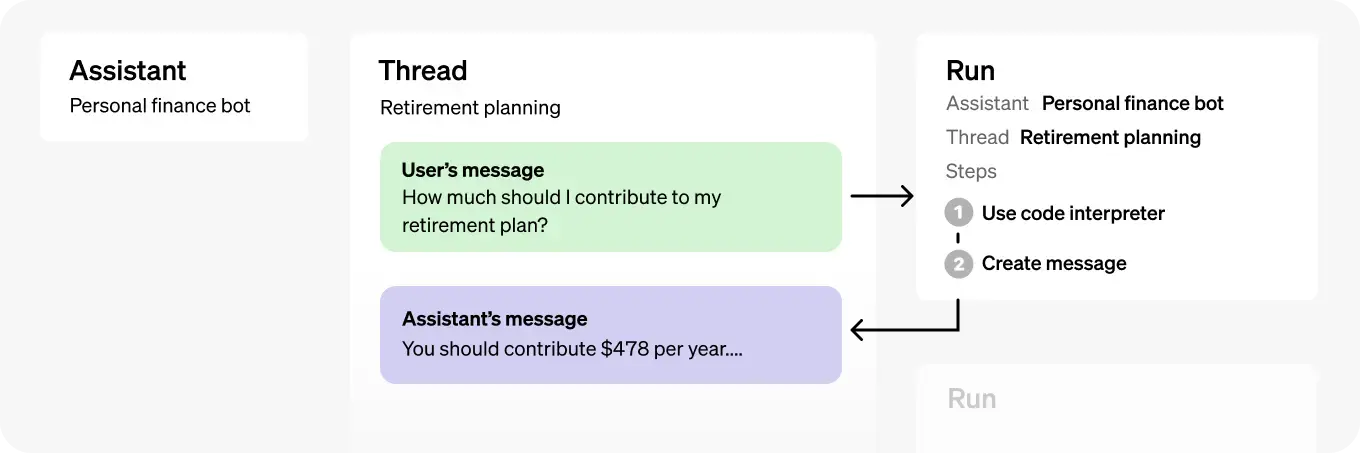

### 3.0 RAG 

RAG - Retrieval Augmented Generation is very common approach while building Gen AI applications. It is often combined with other prompt engineering techniques I have shared above. RAG itself is very vast topic. To understand RAG concepts and review examples shared under my [AIExemplar GIT Repo](https://github.com/nileshvj2/AIExemplar). 

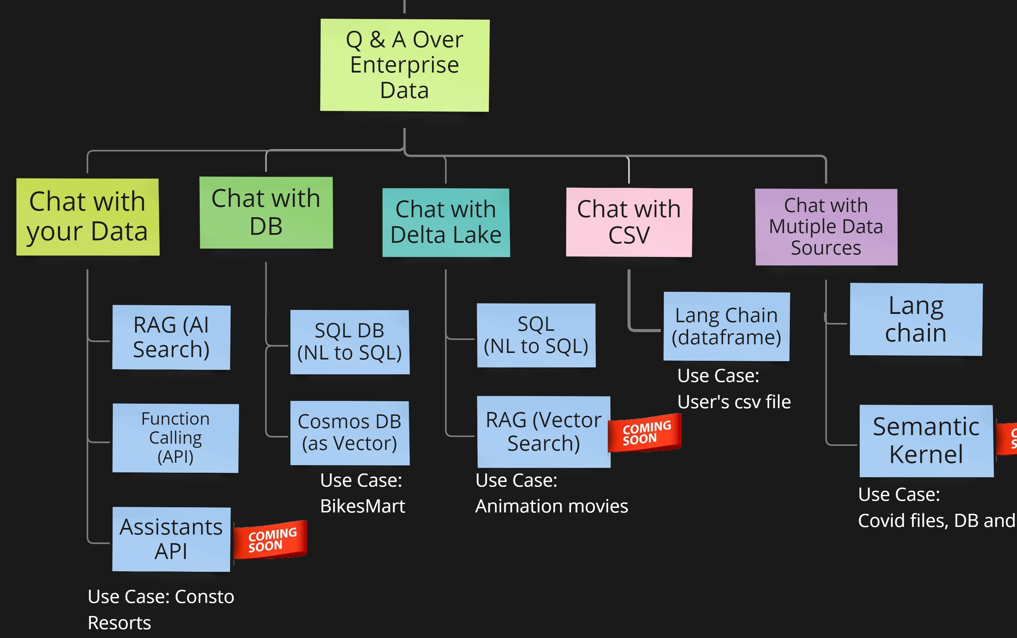

### 3.1 Automatic Prompt Engineering

Automatic prompt engineering is a technique where you will use power of LLMs to come up with best prompts. Instead of manually generating prompts, you will provide handful of input-output pairs and use LLM to generate prompt that along with the same inputs, would result in the similar outputs.
This requires 2 LLMs - a prompt generator (which produces prompts) and a content generator (which given a prompt produces actual output). 

Reference: [arxiv research paper](https://arxiv.org/abs/2211.01910?utm_campaign=The%20Batch&utm_source=hs_email&utm_medium=email&_hsenc=p2ANqtz-_NI0riVg2MTygpGvzNa7DXL56dJ2LjHkJoe2AkDTfZfN8MvbcNRAimpQmPvjNrJ9gp98d6)

Refer below simple example how LLM can be used to generate prompts.

In [8]:
prompt = """You are prompt generator which will generate a prompt for large language model based on examples given below:
Input: prove
Output: disprove
Input: happy
Output: sad
Input: true
Output: false
Input: big
Output: small
Input: up
Output: down
Input: in
Output: out
Make sure to generate a prompt which is concise and less than 500 characters. Dont include any examples in the prompt and make it as generic as possible.
"""

messages = [
    {
        "role": "user",
        "content": prompt
    }
]
params = {
    "temperature": 1,
    "max_tokens": 100,
    "top_p": 1,
    "frequency_penalty": 0,
    "presence_penalty": 0
}
response = get_completion(params, messages)
IPython.display.Markdown(response.choices[0].message.content)

Generate a prompt for large language model based on antonyms to the given words.

### 3.2 Active Prompt

Automatic prompt engineering is a technique where you will use power of LLMs to come up with best prompts. Instead of manually generating prompts, you will provide handful of input-output pairs and use LLM to generate prompt that along with the same inputs, would result in the similar outputs.
This requires 2 LLMs - a prompt generator (which produces prompts) and a content generator (which given a prompt produces actual output). 

Reference: [arxiv research paper](https://arxiv.org/pdf/2302.12246.pdf)

Refer below simple example how LLM can be used to generate prompts.